In [1]:

# ------------------IMPORT LIBRARIES-----------------
import tensorflow as tf
import numpy as np
import random
import keras_tuner as kt
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd 
import json
import os 
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from time import perf_counter

2024-07-08 11:14:32.767414: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# --------------DEFINE FUNCTIONS OF MODELS-----------
# Static Models
def pca_mlp(pc_num):
	x_test=np.load('./pca-test.npy')
	df_test=pd.read_csv('./Test_full_set.csv')
	y_test=np.array(df_test['Heat Flux'].tolist())
	x_test=x_test[:,:pc_num]


	# filter out lower heat flux data
	condition=y_test>15
	x_test=x_test[condition]
	y_test=y_test[condition]


	# Define Model
	def model_def():
		input_=tf.keras.layers.Input(shape=(pc_num))
		hp_layer1=1700
		hp_layer2=1000
		hp_layer3=100
		hp_layer4=800
		hp_layer5=600
		x=tf.keras.layers.Dense(hp_layer1, activation='relu')(input_)
		x=tf.keras.layers.Dense(hp_layer2, activation='relu')(x)
		x=tf.keras.layers.Dense(hp_layer3, activation='relu')(x)
		x=tf.keras.layers.Dense(hp_layer4, activation='relu')(x)
		x=tf.keras.layers.Dense(hp_layer5, activation='relu')(x)
		x=tf.keras.layers.Dense(1)(x)
		hp_learning_rate=0.0001
		model=tf.keras.Model(inputs=input_, outputs=x)
		model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='MSE')
				
		return model
		
		
	checkpoint=ModelCheckpoint(f"./pca-mlp-pc{pc_num}-model-best.hdf5", save_best_only=True, save_weights_only=True, mode='min')
		
	stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
	model=model_def()
	model.load_weights(f"./pca-mlp-pc{pc_num}-model-best.hdf5")
	start=perf_counter()
	pred=model.predict(x_test)
	stop=perf_counter()
	print('Time', stop-start, 'Total Data:', len(x_test))
	return pred, y_test
print('PCA')
pca_mlp(900)
	
def cnn_static_model():
	csv_test_loc="./Test_full_set.csv"
	img_w,img_h=200,200
	dftest=pd.read_csv(csv_test_loc)
	dftest=dftest.to_numpy()
	condition=dftest[:,1]>15
	dftest=dftest[condition]
	amounttest=len(dftest)



	test_data={'Image': (np.array(dftest[:,3]).astype('U')),
		    'Heat Flux': (np.array(dftest[:,1]).astype('float'))}


	    
	@tf.function
	def load_and_preprocess_image(path):
	    image_string = tf.io.read_file(path)
	    img = tf.io.decode_png(image_string, channels=1)
	    img = tf.image.resize(img, [img_w, img_h])
	    img = tf.cast(img, tf.float32) / 255.0 
	    return img

	def load_and_preprocess_from_path_labels(image_path, labels):
	    image = load_and_preprocess_image(image_path)
	    return image, labels

	def configure_for_performance(ds):
	    ds = ds.cache()
	    
	    ds = ds.batch(50)
	    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
	    return ds

	test_ds = tf.data.Dataset.from_generator(lambda: zip(test_data['Image'], test_data['Heat Flux']), (tf.string, tf.float32))
	test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)
	test_ds = configure_for_performance(test_ds)



	for s1,s3 in test_ds.take(1):
	    print("Image shape: ", s1.numpy().shape)
	    print("Label: ", s3.numpy().shape)


	# Define Model
	def model_def():
		input_=tf.keras.layers.Input(shape=(200,200,1))
		hp_activation='relu'
		hp_layer1_filter=62
		hp_layer1_kernel=3
		hp_layer1_stride=1
		x=tf.keras.layers.Conv2D(hp_layer1_filter, hp_layer1_kernel,hp_layer1_stride, activation=hp_activation)(input_)
		hp_layer2_kernel=6
		hp_layer2_stride=3
		x=tf.keras.layers.MaxPool2D(hp_layer2_kernel,hp_layer2_stride)(x)
		x=tf.keras.layers.Dropout(0.2)(x)
		hp_layer3_filter=162
		hp_layer3_kernel=5
		hp_layer3_stride=1
		x=tf.keras.layers.Conv2D(hp_layer3_filter, hp_layer3_kernel,hp_layer3_stride, activation=hp_activation)(x)
		hp_layer4_kernel=4
		hp_layer4_stride=3
		x=tf.keras.layers.MaxPool2D(hp_layer4_kernel, hp_layer4_stride)(x)
		hp_layer5_filter=282
		hp_layer5_kernel=3
		hp_layer5_stride=3
		x=tf.keras.layers.Conv2D(hp_layer5_filter, hp_layer5_kernel,hp_layer5_stride, activation=hp_activation)(x)
		x=tf.keras.layers.GlobalAveragePooling2D()(x)
		x=tf.keras.layers.Dropout(0.2)(x)
		hp_activation1='relu'
		hp_layer6=501
		x=tf.keras.layers.Dense(hp_layer6, activation=hp_activation1)(x)
		hp_layer7=301
		x=tf.keras.layers.Dense(hp_layer7, activation=hp_activation1)(x)
		x=tf.keras.layers.Dense(1)(x)
		hp_learning_rate=0.0001
		model=tf.keras.Model(inputs=input_, outputs=x)
		model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='MSE')
				
		return model

	model=model_def()
	model.load_weights('./cnn-model-best.hdf5')

	start=perf_counter()
	pred=model.predict(test_ds)
	stop=perf_counter()
	print('Time:', stop-start, 'Data:', len(dftest))
	return pred, np.array(dftest[:,1])
print('CNN')
cnn_static_model()
# Sequential Models
def pca_cnn_model(pc_num, seq_len):
	x_test=np.load('./pca-test.npy')
	df_test=pd.read_csv('./Test_full_set.csv')
	y_test=np.array(df_test['Heat Flux'].tolist())
	x_test=x_test[:,:pc_num]
	
	
	def split_data(signal,sl,st):
    		length=len(signal)
    		amt_samples=int((length-sl)/st)
    		data=np.empty((amt_samples,sl))
    		for i in range(amt_samples):
        		data[i]=signal[(i*st):(i*st)+sl]
        
    		return data

	index=[i for i in range(len(x_test))]
	index=split_data(index, seq_len, 1).astype(int)
	x_test=x_test[index]
	y_test=split_data(y_test,seq_len,1)[:,-1]
	print(x_test.shape, y_test.shape)
	condition=y_test>15
	x_test=x_test[condition]
	y_test=y_test[condition]
	
	
	
	amounttest=len(x_test)
	

	x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],x_test.shape[2],1))


	
	# define model
	inputs=tf.keras.Input(shape=(x_test.shape[1],x_test.shape[2],1))
	hp_layer1_filter=72
	hp_layer1_kernel=3
	hp_layer1_stride=3
	x=tf.keras.layers.Conv2D(hp_layer1_filter, hp_layer1_kernel,strides=hp_layer1_stride, activation='relu')(inputs)
	#x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
	x=tf.keras.layers.Dropout(0.2)(x)
	hp_layer2_filter=72
	hp_layer2_kernel=5
	hp_layer2_stride=1
	x = tf.keras.layers.Conv2D(filters=hp_layer2_filter, kernel_size=hp_layer2_kernel,strides= hp_layer2_stride,padding='same', activation='relu')(x)
	hp_layer3_filter=92
	hp_layer3_kernel=5
	hp_layer3_stride=3
	x = tf.keras.layers.Conv2D(filters=hp_layer3_filter, kernel_size=hp_layer3_kernel, strides=hp_layer3_stride, padding='same',activation='relu')(x)
	x = tf.keras.layers.MaxPooling2D(pool_size=2,padding='same')(x)
	hp_layer4_filter=62
	hp_layer4_kernel=3
	hp_layer4_stride=1
	x = tf.keras.layers.Conv2D(filters=hp_layer4_filter, kernel_size=hp_layer4_kernel, strides=hp_layer4_stride,padding='same', activation='relu')(x)
	x=tf.keras.layers.Dropout(0.2)(x)
	#x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
	x = tf.keras.layers.Flatten()(x)
	hp_layer5_neurons=181
	x = tf.keras.layers.Dense(units=hp_layer5_neurons, activation='relu')(x)
	hp_layer6_neurons=931
	x = tf.keras.layers.Dense(units=hp_layer6_neurons, activation='relu')(x)
	outputs = tf.keras.layers.Dense(units=1)(x)

	model=tf.keras.models.Model(inputs=inputs, outputs=outputs)
	
	model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='MSE')
			
	checkpoint=ModelCheckpoint(f"./cnn-pc{pc_num}_sl{seq_len}.hdf5", save_best_only=True, save_weights_only=True, mode='min')
	early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
	model.load_weights(f"./cnn-pc{pc_num}_sl{seq_len}.hdf5")
	
	start=perf_counter()
	predict=model.predict(x_test)
	stop=perf_counter()
	print('Time:', stop-start, 'Data', len(x_test))
	'''
	plt.plot(predict, y_test,'o')
	plt.plot([0,120],[0,120])
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.show()
	'''
	return predict, y_test
pca_cnn_model(40,200)

def pca_fft_model(pc_num, seq_len):
	x_test=np.load('./pca-test.npy')
	df_test=pd.read_csv('./Test_full_set.csv')
	y_test=np.array(df_test['Heat Flux'].tolist())
	x_test=x_test[:,:pc_num]
	
	
	def split_data(signal,sl,st):
    		length=len(signal)
    		amt_samples=int((length-sl)/st)
    		data=np.empty((amt_samples,sl))
    		for i in range(amt_samples):
        		data[i]=signal[(i*st):(i*st)+sl]
        
    		return data

	index=[i for i in range(len(x_test))]
	index=split_data(index, seq_len, 1).astype(int)
	x_test=x_test[index]
	y_test=split_data(y_test,seq_len,1)[:,-1]
	print(x_test.shape, y_test.shape)
	condition=y_test>15
	x_test=x_test[condition]
	y_test=y_test[condition]
	
	def convert_sequences_to_frequency_intensities(sequences, subtract_mean=True):
		N, seqlen,_ = sequences.shape
		if subtract_mean:
			sequences -= np.mean(sequences, axis=1, keepdims=True)
		fft_result = np.fft.fft(sequences, axis=1) 
		frequency_intensities = np.abs(fft_result[:, :seqlen // 2,:])
		return frequency_intensities
	start=perf_counter()
	x_test=convert_sequences_to_frequency_intensities(x_test)
	stop=perf_counter()
	print('FFT Time:', stop-start, 'data', len(x_test)) 
	
	x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
	print(x_test.shape)
	
	
	# define model
	inputs=tf.keras.Input(shape=(x_test.shape[1],x_test.shape[2],1))
	x = tf.keras.layers.Conv2D(filters=72, kernel_size=3,strides=3, padding='same',activation='relu')(inputs)
	#x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
	x=tf.keras.layers.Dropout(0.2)(x)
	x = tf.keras.layers.Conv2D(filters=62, kernel_size=3,strides=1,padding='same', activation='relu')(x)
	x = tf.keras.layers.Conv2D(filters=42, kernel_size=3,strides=1, padding='same',activation='relu')(x)
	x = tf.keras.layers.MaxPooling2D(pool_size=2,padding='same')(x)
	x = tf.keras.layers.Conv2D(filters=42, kernel_size=5,strides=1,padding='same', activation='relu')(x)
	x=tf.keras.layers.Dropout(0.2)(x)
	#x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
	x = tf.keras.layers.Flatten()(x)
	x = tf.keras.layers.Dense(units=851, activation='relu')(x)
	x = tf.keras.layers.Dense(units=321, activation='relu')(x)
	outputs = tf.keras.layers.Dense(units=1)(x)

	model=tf.keras.models.Model(inputs=inputs, outputs=outputs)
	model.load_weights(f"./pca_fft_pc{pc_num}_sl{seq_len}.hdf5")
	
	start=perf_counter()
	predict=model.predict(x_test)
	stop=perf_counter()
	print('Time', stop-start, 'Data', len(x_test))
	'''
	plt.plot(predict, y_test,'o')
	plt.plot([0,120],[0,120])
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.show()
	'''
	return predict, y_test
print('PCA-FFT')
pca_fft_model(40,200)
	
def lstm_model(pc_num, seq_len):
	x_test=np.load('./pca-test.npy')
	df_test=pd.read_csv('./Test_full_set.csv')
	y_test=np.array(df_test['Heat Flux'].tolist())
	x_test=x_test[:,:pc_num]
	
	
	def split_data(signal,sl,st):
    		length=len(signal)
    		amt_samples=int((length-sl)/st)
    		data=np.empty((amt_samples,sl))
    		for i in range(amt_samples):
        		data[i]=signal[(i*st):(i*st)+sl]
        
    		return data

	index=[i for i in range(len(x_test))]
	index=split_data(index, seq_len, 1).astype(int)
	x_test=x_test[index]
	y_test=split_data(y_test,seq_len,1)[:,-1]
	print(x_test.shape, y_test.shape)
	condition=y_test>15
	x_test=x_test[condition]
	y_test=y_test[condition]
	
	# define model
	def model_def():
		input_=tf.keras.layers.Input(shape=(seq_len, pc_num))
		hp_layer1=590
		x=tf.keras.layers.LSTM(hp_layer1,  return_sequences=True)(input_)
		x=tf.keras.layers.Dropout(0.2)(x)
		hp_layer2=990
		x=tf.keras.layers.LSTM(hp_layer2,  return_sequences=True)(x)
		hp_layer3=490
		x=tf.keras.layers.LSTM(hp_layer3,  return_sequences=True)(x)
		x=tf.keras.layers.Dropout(0.2)(x)
		hp_layer4=930
		x=tf.keras.layers.LSTM(hp_layer4,  return_sequences=True)(x)
		x=tf.keras.layers.Dropout(0.2)(x)
		hp_layer5=190
		x=tf.keras.layers.LSTM(hp_layer5,  return_sequences=True)(x)
		x=tf.keras.layers.Dropout(0.2)(x)
		hp_layer6=560
		x=tf.keras.layers.LSTM(hp_layer6)(x)
		hp_layer7=260
		x=tf.keras.layers.Dense(hp_layer7, activation='relu')(x)
		hp_layer8=440
		x=tf.keras.layers.Dense(hp_layer8, activation='relu')(x)
		hp_layer9=120
		x=tf.keras.layers.Dense(hp_layer9, activation='relu')(x)
		hp_layer10=870
		x=tf.keras.layers.Dense(hp_layer10, activation='relu')(x)
		x=tf.keras.layers.Dense(1)(x)
		model=tf.keras.models.Model(inputs=input_,outputs=x)
		hp_lr=0.001
		model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),loss='MSE')
		return model
		
	model=model_def()

	

	model=model_def()
	model.load_weights(f"./lstm_pc{pc_num}_sl{seq_len}-model-best.hdf5")
	start=perf_counter()
	predict=model.predict(x_test)
	stop=perf_counter()
	print('Time', stop-start, 'Data', len(x_test))
	return predict, y_test
print('LSTM')
lstm_model(40,200)

def pcamlp_model(pc_num, seq_len):
	x_test=np.load('./pca-test.npy')
	df_test=pd.read_csv('./Test_full_set.csv')
	y_test=np.array(df_test['Heat Flux'].tolist())
	x_test=x_test[:,:pc_num]

	def split_data(signal,sl,st):
		length=len(signal)
		amt_samples=int((length-sl)/st)
		data=np.empty((amt_samples,sl))
		for i in range(amt_samples):
			data[i]=signal[(i*st):(i*st)+sl]

		return data

	index=[i for i in range(len(x_test))]
	index=split_data(index, seq_len, 1).astype(int)
	x_test=x_test[index]
	y_test=split_data(y_test,seq_len,1)[:,-1]
	print(x_test.shape, y_test.shape)



	x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))


	# filter out lower heat flux data
	condition=y_test>15
	x_test=x_test[condition]
	y_test=y_test[condition]
	
	
	# define model
	inputs=tf.keras.Input(shape=(x_test.shape[1]))
	hp_layer1=500
	x=tf.keras.layers.Dense(hp_layer1, activation='relu')(inputs)
	x=tf.keras.layers.Dropout(0.2)(x)
	hp_layer2=1300
	x = tf.keras.layers.Dense(hp_layer2, activation='relu')(x)
	hp_layer3=50
	x = tf.keras.layers.Dense(hp_layer3,activation='relu')(x)
	hp_layer4=1850
	x = tf.keras.layers.Dense(hp_layer4,activation='relu')(x)
	x=tf.keras.layers.Dropout(0.2)(x)
	outputs = tf.keras.layers.Dense(units=1)(x)


	model=tf.keras.models.Model(inputs=inputs, outputs=outputs)
	
	model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='MSE')
			
	model.load_weights(f"./mlp-pc{pc_num}_sl{seq_len}.hdf5")
	start=perf_counter()
	predict=model.predict(x_test)
	stop=perf_counter()
	print('Time', stop-start, 'data', len(x_test))
	'''
	plt.plot(predict, y_test,'o')
	plt.plot([0,120],[0,120])
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.show()
	'''
	return predict, y_test
print('PCA-MLP-Seq')
pcamlp_model(40,200)


PCA


2024-07-08 11:14:36.683368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-08 11:14:36.683605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-08 11:14:36.711059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-08 11:14:36.711158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-08 11:14:36.711221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

273/273 [==============================] - 0s 557us/step


2024-07-08 11:14:37.621480: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Time 0.5480525110615417 Total Data: 8712
CNN
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape:  (50, 200, 200, 1)
Label:  (50,)


2024-07-08 11:14:37.976687: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-07-08 11:14:38.186703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


175/175 [==============================] - 10s 53ms/step
Time: 9.660573745961301 Data: 8712
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.508169705979526 Data 8711
PCA-FFT
(12711, 200, 40) (12711,)
FFT Time: 0.796248191036284 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 0s 718us/step
Time 0.3331630879547447 Data 8711
LSTM
(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 52ms/step
Time 15.117871816968545 Data 8711
PCA-MLP-Seq
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 2ms/step
Time 0.5822078179335222 data 8711


(array([[ 71.27664],
        [ 66.11406],
        [ 68.7881 ],
        ...,
        [100.03457],
        [ 98.38002],
        [ 98.43809]], dtype=float32),
 array([15.36361124, 15.36361124, 15.36361124, ..., 98.11832227,
        98.11832227, 98.11832227]))

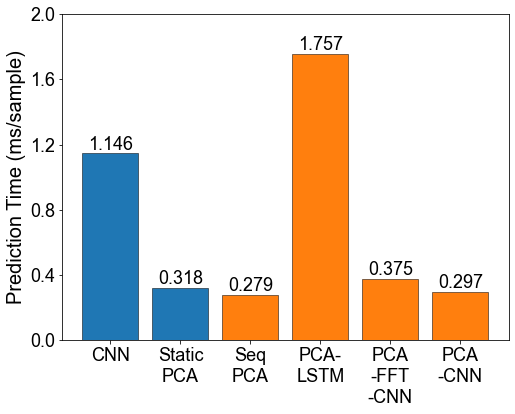

In [3]:
# ------------------CREATE FIGURES-------------------
# bar graph for R2 values
from matplotlib.ticker import MaxNLocator

arial_font_path='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
arial=font_manager.FontProperties(fname=arial_font_path, size=18)
categories=['CNN','Static\nPCA','Seq\nPCA', 'PCA-\nLSTM','PCA\n-FFT\n-CNN','PCA\n-CNN']
plt.figure(figsize=(8,6))
ttime=np.array([1.145774,0.3184,0.279166,1.7569,0.374878, 0.297123])
colors=['#1F77B4','#1F77B4','#FF7F0E','#FF7F0E','#FF7F0E','#FF7F0E']
plt.ylabel('Prediction Time (ms/sample)',fontproperties=arial,fontsize=20)
bars=plt.bar(categories, ttime,color=colors, edgecolor='black', linewidth=0.5)
plt.xticks(fontproperties=arial, fontsize=18)
plt.yticks(fontproperties=arial, fontsize=18)
plt.ylim(0,2)
plt.gca().yaxis.set_major_locator(MaxNLocator(5))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}",
            ha='center', va='bottom', fontproperties=arial, fontsize=18)

plt.savefig('./Figures/time.png')      
plt.show()




Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape:  (50, 200, 200, 1)
Label:  (50,)
      1/Unknown - 0s 103ms/step

2024-07-08 11:15:16.979825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 [==============================] - 9s 53ms/step
Time: 9.345354954013601 Data: 8712
273/273 [==============================] - 0s 1ms/step
Time 0.34590999700594693 Total Data: 8712
(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 54ms/step
Time 15.508912133052945 Data 8711
(12711, 200, 40) (12711,)
FFT Time: 0.8040870419936255 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 1s 2ms/step
Time 0.6321597110945731 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.43502947490196675 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 615us/step
Time 0.3254785999888554 data 8711
[0.8563883  0.857902   0.91613075 0.96165838 0.91867384 0.97423953]


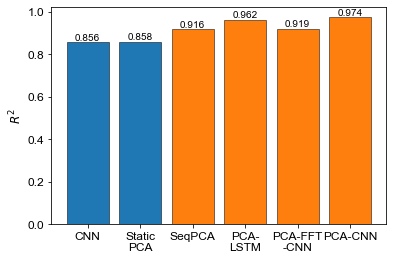

In [4]:

categories=['CNN','Static\nPCA','SeqPCA', 'PCA-\nLSTM','PCA-FFT\n-CNN','PCA-CNN']

r2_vals=np.empty(6)
pred,ytest=cnn_static_model()
r2_vals[0]=r2_score(ytest,pred)
pred,ytest=pca_mlp(900)
r2_vals[1]=r2_score(ytest,pred)
pred,ytest=lstm_model(40,200)
r2_vals[3]=r2_score(ytest,pred)
pred,ytest=pca_fft_model(40,200)
r2_vals[4]=r2_score(ytest,pred)
pred,ytest=pca_cnn_model(40,200)
r2_vals[5]=r2_score(ytest,pred)
pred,ytest=pcamlp_model(40,200)
r2_vals[2]=r2_score(ytest,pred)
print(r2_vals)
colors=['#1F77B4','#1F77B4','#FF7F0E','#FF7F0E','#FF7F0E','#FF7F0E']
plt.ylabel(r'$R^2$',fontproperties=arial,fontsize=12)
bars=plt.bar(categories, r2_vals,color=colors, edgecolor='black', linewidth=0.5)
plt.xticks(fontproperties=arial, fontsize=12)
plt.yticks(fontproperties=arial, fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}",
            ha='center', va='bottom', fontproperties=arial, fontsize=10)

plt.savefig('./Figures/r2.png')      
plt.show()

Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape:  (50, 200, 200, 1)
Label:  (50,)
      1/Unknown - 0s 101ms/step

2024-03-14 14:18:04.063688: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 [==============================] - 16s 93ms/step
Time: 16.3194893959444 Data: 8712
273/273 [==============================] - 0s 611us/step
Time 0.24059184384532273 Total Data: 8712
(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 53ms/step
Time 15.239339947933331 Data 8711
(12711, 200, 40) (12711,)
FFT Time: 0.7785425209440291 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 0s 629us/step
Time 0.28943571797572076 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.44519935292191803 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 644us/step
Time 0.32839056802913547 data 8711
[11.5214674  11.89939001  9.98818306  7.76709863  9.66740723  7.01751782]


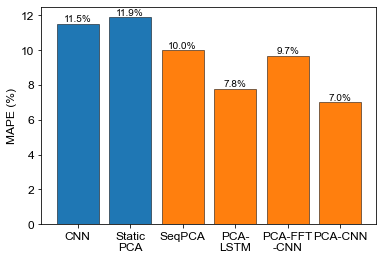

In [6]:
# Plot MAPE
categories=['CNN','Static\nPCA','SeqPCA', 'PCA-\nLSTM','PCA-FFT\n-CNN','PCA-CNN']

mape_vals=np.empty(6)
pred,ytest=cnn_static_model()
mape_vals[0]=mean_absolute_percentage_error(ytest,pred)
pred,ytest=pca_mlp(900)
mape_vals[1]=mean_absolute_percentage_error(ytest,pred)
pred,ytest=lstm_model(40,200)
mape_vals[3]=mean_absolute_percentage_error(ytest,pred)
pred,ytest=pca_fft_model(40,200)
mape_vals[4]=mean_absolute_percentage_error(ytest,pred)
pred,ytest=pca_cnn_model(40,200)
mape_vals[5]=mean_absolute_percentage_error(ytest,pred)
pred,ytest=pcamlp_model(40,200)
mape_vals[2]=mean_absolute_percentage_error(ytest,pred)
#mape_vals=mape_vals*100
mape_vals *= 100

print(mape_vals)
colors=['#1F77B4','#1F77B4','#FF7F0E','#FF7F0E','#FF7F0E','#FF7F0E']
plt.ylabel(r'MAPE (%)',fontproperties=arial,fontsize=12)
bars=plt.bar(categories, mape_vals,color=colors, edgecolor='black', linewidth=0.5)
plt.xticks(fontproperties=arial, fontsize=12)
plt.yticks(fontproperties=arial, fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.1f}%",
            ha='center', va='bottom', fontsize=10, fontproperties=arial)

            
plt.savefig('./Figures/mape.png')      
plt.show()


Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape:  (50, 200, 200, 1)
Label:  (50,)
      1/Unknown - 0s 113ms/step

2024-03-14 17:01:11.253458: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 [==============================] - 10s 58ms/step
Time: 10.29406060418114 Data: 8712


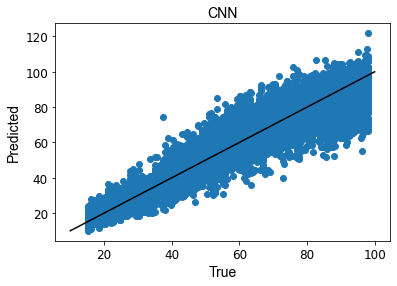

273/273 [==============================] - 0s 463us/step
Time 0.1872494660783559 Total Data: 8712


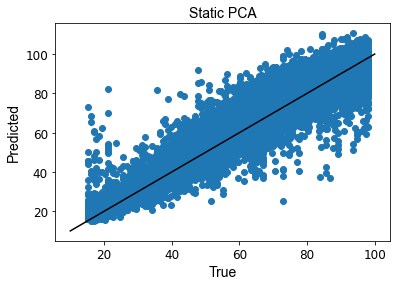

(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 52ms/step
Time 14.933671542908996 Data 8711


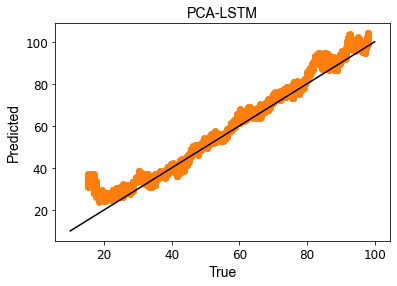

(12711, 200, 40) (12711,)
FFT Time: 0.7897879860829562 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 0s 1ms/step
Time 0.4678681609220803 Data 8711


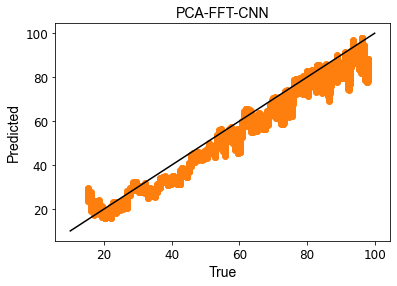

(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.44350202986970544 Data 8711


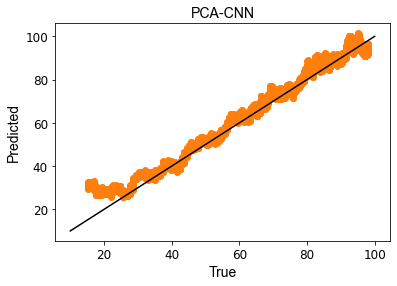

Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape:  (50, 200, 200, 1)
Label:  (50,)
      1/Unknown - 0s 112ms/step

2024-03-14 17:01:42.039660: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 [==============================] - 10s 54ms/step
Time: 9.544887742958963 Data: 8712
273/273 [==============================] - 0s 433us/step
Time 0.17789089982397854 Total Data: 8712
(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 53ms/step
Time 15.127721233991906 Data 8711
(12711, 200, 40) (12711,)
FFT Time: 0.7859631411265582 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 0s 1ms/step
Time 0.5027952778618783 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.47904474195092916 Data 8711
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this 

2024-03-14 17:02:12.155482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 [==============================] - 9s 53ms/step
Time: 9.42073733289726 Data: 8712
273/273 [==============================] - 0s 504us/step
Time 0.19947262713685632 Total Data: 8712
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 538us/step
Time 0.31174776004627347 data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 53ms/step
Time 15.229111153166741 Data 8711
(12711, 200, 40) (12711,)
FFT Time: 0.7904714879114181 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 0s 735us/step
Time 0.32113902806304395 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 2ms/step
Time: 0.5946828378364444 Data 8711


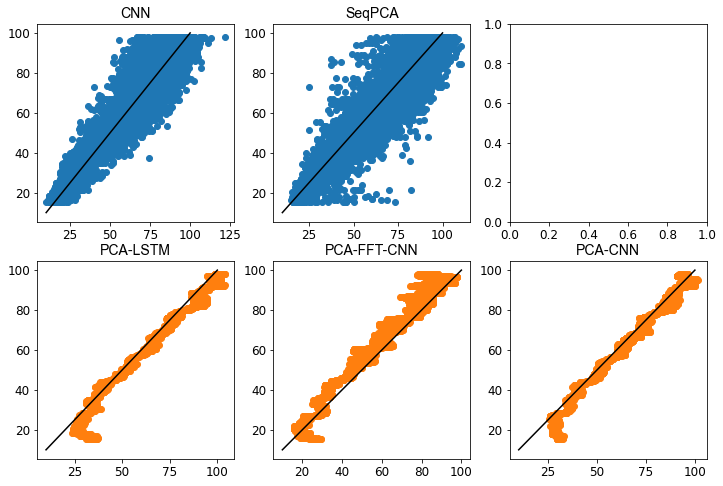

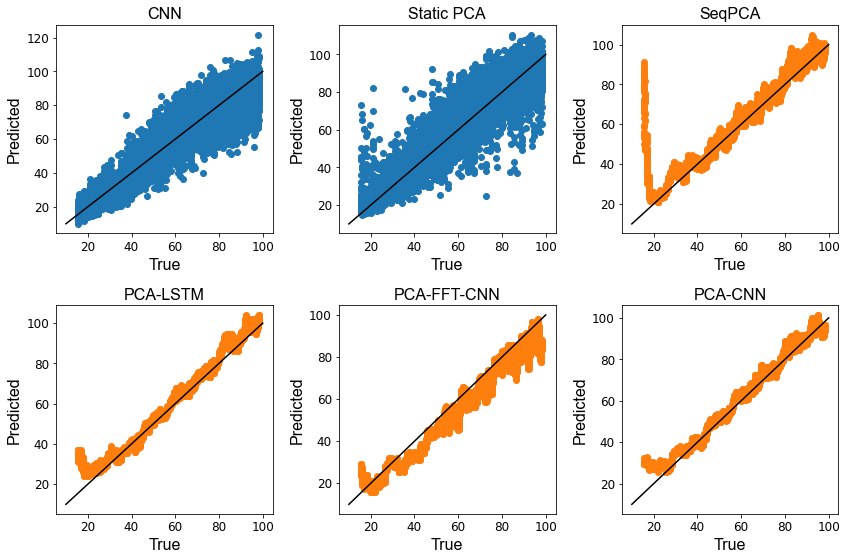

In [9]:
# Pred Vs True Plots
'''
'''
plt.rcParams.update({'font.size': 14,    # Default font size
                     'axes.titlesize': 20,   # Title font size
                     'axes.labelsize': 16,   # Axes label font size
                     'xtick.labelsize': 12,  # X-axis tick label font size
                     'ytick.labelsize': 12}) # Y-axis tick label font size
# seperate plots
pred,ytest=cnn_static_model()
plt.plot(ytest,pred, 'o', color='#1F77B4')
plt.plot([10,100],[10,100], color='black')
plt.title('CNN',fontproperties=arial, fontsize=14)
plt.xlabel('True', fontproperties=arial, fontsize=14)
plt.ylabel('Predicted', fontproperties=arial, fontsize=14)
plt.show()

pred,ytest=pca_mlp(900)
plt.plot(ytest,pred, 'o', color='#1F77B4')
plt.plot([10,100],[10,100], color='black')
plt.title('Static PCA',fontproperties=arial, fontsize=14)
plt.xlabel('True', fontproperties=arial, fontsize=14)
plt.ylabel('Predicted', fontproperties=arial, fontsize=14)
plt.show()

pred,ytest=lstm_model(40,200)
plt.plot(ytest,pred, 'o', color='#FF7F0E')
plt.plot([10,100],[10,100], color='black')
plt.title('PCA-LSTM',fontproperties=arial, fontsize=14)
plt.xlabel('True', fontproperties=arial, fontsize=14)
plt.ylabel('Predicted', fontproperties=arial, fontsize=14)
plt.show()

pred,ytest=pca_fft_model(40,200)
plt.plot(ytest,pred, 'o', color='#FF7F0E')
plt.plot([10,100],[10,100], color='black')
plt.title('PCA-FFT-CNN',fontproperties=arial, fontsize=14)
plt.xlabel('True', fontproperties=arial, fontsize=14)
plt.ylabel('Predicted', fontproperties=arial, fontsize=14)
plt.show()

pred,ytest=pca_cnn_model(40,200)
plt.plot(ytest,pred, 'o', color='#FF7F0E')
plt.plot([10,100],[10,100], color='black')
plt.title('PCA-CNN',fontproperties=arial, fontsize=14)
plt.xlabel('True', fontproperties=arial, fontsize=14)
plt.ylabel('Predicted', fontproperties=arial, fontsize=14)
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot the figures on the grid

pred,ytest=cnn_static_model()
axs[0, 0].plot(pred,ytest, 'o', color='#1F77B4')
axs[0,0].plot([10,100],[10,100], color='black')
axs[0, 0].set_title('CNN',fontproperties=arial, fontsize=14)

pred,ytest=pca_mlp(900)
axs[0, 1].plot(pred,ytest, 'o', color='#1F77B4')
axs[0,1].plot([10,100],[10,100], color='black')
axs[0,1].set_title('SeqPCA',fontproperties=arial, fontsize=14)
pred,ytest=lstm_model(40,200)
axs[1, 0].plot(pred,ytest, 'o', color='#FF7F0E')
axs[1,0].plot([10,100],[10,100], color='black')
axs[1, 0].set_title('PCA-LSTM',fontproperties=arial, fontsize=14)
pred,ytest=pca_fft_model(40,200)
axs[1, 1].plot(pred,ytest, 'o', color='#FF7F0E')
axs[1,1].plot([10,100],[10,100], color='black')
axs[1, 1].set_title('PCA-FFT-CNN',fontproperties=arial, fontsize=14)
pred,ytest=pca_cnn_model(40,200)
axs[1, 2].plot(pred,ytest, 'o', color='#FF7F0E')
axs[1,2].plot([10,100],[10,100], color='black')
axs[1, 2].set_title('PCA-CNN',fontproperties=arial, fontsize=14)
'''
'''
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# First subplot
pred, ytest = cnn_static_model()
axs[0, 0].plot(ytest, pred, 'o', color='#1F77B4')
axs[0, 0].plot([10, 100], [10, 100], color='black')
axs[0, 0].set_title('CNN', fontproperties=arial)
axs[0, 0].set_xlabel('True', fontproperties=arial)
axs[0, 0].set_ylabel('Predicted', fontproperties=arial)

# Second subplot
pred, ytest = pca_mlp(900)
axs[0, 1].plot(ytest, pred, 'o', color='#1F77B4')
axs[0, 1].plot([10, 100], [10, 100], color='black')
axs[0, 1].set_title('Static PCA', fontproperties=arial)
axs[0, 1].set_xlabel('True', fontproperties=arial)
axs[0, 1].set_ylabel('Predicted', fontproperties=arial)

pred, ytest = pcamlp_model(40,200)
axs[0, 2].plot(ytest, pred, 'o', color='#FF7F0E')
axs[0, 2].plot([10, 100], [10, 100], color='black')
axs[0, 2].set_title('SeqPCA', fontproperties=arial)
axs[0, 2].set_xlabel('True', fontproperties=arial)
axs[0, 2].set_ylabel('Predicted', fontproperties=arial)

# Third subplot
pred, ytest = lstm_model(40, 200)
axs[1, 0].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 0].plot([10, 100], [10, 100], color='black')
axs[1, 0].set_title('PCA-LSTM', fontproperties=arial)
axs[1, 0].set_xlabel('True', fontproperties=arial)
axs[1, 0].set_ylabel('Predicted', fontproperties=arial)

# Fourth subplot
pred, ytest = pca_fft_model(40, 200)
axs[1, 1].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 1].plot([10, 100], [10, 100], color='black')
axs[1, 1].set_title('PCA-FFT-CNN', fontproperties=arial)
axs[1, 1].set_xlabel('True', fontproperties=arial)
axs[1, 1].set_ylabel('Predicted', fontproperties=arial)

# Fifth subplot
pred, ytest = pca_cnn_model(40, 200)
axs[1, 2].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 2].plot([10, 100], [10, 100], color='black')
axs[1, 2].set_title('PCA-CNN', fontproperties=arial)
axs[1, 2].set_xlabel('True', fontproperties=arial)
axs[1, 2].set_ylabel('Predicted', fontproperties=arial)
# Hide the remaining empty subplots
#axs[0, 2].axis('off')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.savefig('./Figures/predvstrue.png')      
plt.show()

Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape:  (50, 200, 200, 1)
Label:  (50,)
      1/Unknown - 0s 109ms/step

2024-07-08 11:25:12.066398: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 [==============================] - 10s 58ms/step
Time: 10.162311575026251 Data: 8712
273/273 [==============================] - 0s 495us/step
Time 0.19257753295823932 Total Data: 8712
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 627us/step
Time 0.33142929605674 data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 53ms/step
Time 15.103883305913769 Data 8711
(12711, 200, 40) (12711,)
FFT Time: 0.815570538979955 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 0s 682us/step
Time 0.30036444996949285 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.44283663504756987 Data 8711


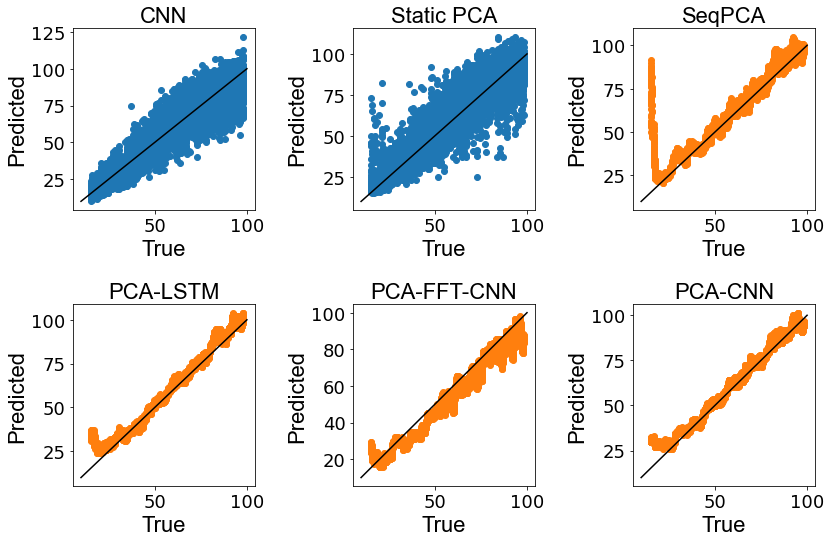

In [8]:

plt.rcParams.update({'font.size': 22,    # Default font size
                     'axes.titlesize': 24,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18})

arial_font_path='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
arial=font_manager.FontProperties(fname=arial_font_path)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# First subplot
pred, ytest = cnn_static_model()
axs[0, 0].plot(ytest, pred, 'o', color='#1F77B4')
axs[0, 0].plot([10, 100], [10, 100], color='black')
axs[0, 0].set_title('CNN', fontproperties=arial)
axs[0, 0].set_xlabel('True', fontproperties=arial)
axs[0, 0].set_ylabel('Predicted', fontproperties=arial)

# Second subplot
pred, ytest = pca_mlp(900)
axs[0, 1].plot(ytest, pred, 'o', color='#1F77B4')
axs[0, 1].plot([10, 100], [10, 100], color='black')
axs[0, 1].set_title('Static PCA', fontproperties=arial)
axs[0, 1].set_xlabel('True', fontproperties=arial)
axs[0, 1].set_ylabel('Predicted', fontproperties=arial)

pred, ytest = pcamlp_model(40,200)
axs[0, 2].plot(ytest, pred, 'o', color='#FF7F0E')
axs[0, 2].plot([10, 100], [10, 100], color='black')
axs[0, 2].set_title('SeqPCA', fontproperties=arial)
axs[0, 2].set_xlabel('True', fontproperties=arial)
axs[0, 2].set_ylabel('Predicted', fontproperties=arial)

# Third subplot
pred, ytest = lstm_model(40, 200)
axs[1, 0].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 0].plot([10, 100], [10, 100], color='black')
axs[1, 0].set_title('PCA-LSTM', fontproperties=arial)
axs[1, 0].set_xlabel('True', fontproperties=arial)
axs[1, 0].set_ylabel('Predicted', fontproperties=arial)

# Fourth subplot
pred, ytest = pca_fft_model(40, 200)
axs[1, 1].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 1].plot([10, 100], [10, 100], color='black')
axs[1, 1].set_title('PCA-FFT-CNN', fontproperties=arial)
axs[1, 1].set_xlabel('True', fontproperties=arial)
axs[1, 1].set_ylabel('Predicted', fontproperties=arial)

# Fifth subplot
pred, ytest = pca_cnn_model(40, 200)
axs[1, 2].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 2].plot([10, 100], [10, 100], color='black')
axs[1, 2].set_title('PCA-CNN', fontproperties=arial)
axs[1, 2].set_xlabel('True', fontproperties=arial)
axs[1, 2].set_ylabel('Predicted', fontproperties=arial)
# Hide the remaining empty subplots
#axs[0, 2].axis('off')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.savefig('./Figures/predvstrue.png')      
plt.show()

Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Image shape:  (50, 200, 200, 1)
Label:  (50,)
      1/Unknown - 0s 118ms/step

2024-07-08 12:19:53.232844: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


175/175 [==============================] - 9s 53ms/step
Time: 9.353254143963568 Data: 8712
273/273 [==============================] - 0s 487us/step
Time 0.19555140403099358 Total Data: 8712
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 639us/step
Time 0.33058610500302166 data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 15s 53ms/step
Time 15.141402595909312 Data 8711
(12711, 200, 40) (12711,)
FFT Time: 0.8062625878956169 data 8711
(8711, 100, 40, 1)
273/273 [==============================] - 0s 810us/step
Time 0.33207234600558877 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.5815167500404641 Data 8711


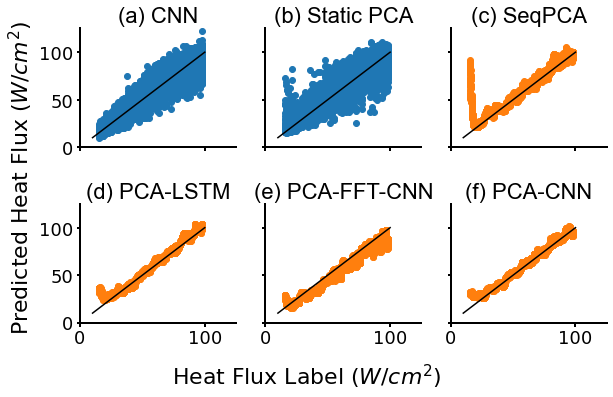

In [41]:

plt.rcParams.update({'font.size': 22,    # Default font size
                     'axes.titlesize': 24,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18})

arial_font_path='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
arial=font_manager.FontProperties(fname=arial_font_path)

fig, axs = plt.subplots(2, 3, figsize=(9,6))
# First subplot
pred, ytest = cnn_static_model()
axs[0, 0].plot(ytest, pred, 'o', color='#1F77B4')
axs[0, 0].plot([10, 100], [10, 100], color='black')
axs[0, 0].set_title('(a) CNN', fontproperties=arial)
#axs[0, 0].set_xlabel('True', fontproperties=arial)
#axs[0, 0].set_ylabel('Predicted', fontproperties=arial)
axs[0,0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
axs[0,0].tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
axs[0,0].set_xlim([0,125])
axs[0,0].set_ylim([0,125])
# Second subplot
pred, ytest = pca_mlp(900)
axs[0, 1].plot(ytest, pred, 'o', color='#1F77B4')
axs[0, 1].plot([10, 100], [10, 100], color='black')
axs[0, 1].set_title('(b) Static PCA', fontproperties=arial)
#axs[0, 1].set_xlabel('True', fontproperties=arial)
#axs[0, 1].set_ylabel('Predicted', fontproperties=arial)
axs[0,1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
axs[0,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
axs[0,1].set_xlim([0,125])
axs[0,1].set_ylim([0,125])

pred, ytest = pcamlp_model(40,200)
axs[0, 2].plot(ytest, pred, 'o', color='#FF7F0E')
axs[0, 2].plot([10, 100], [10, 100], color='black')
axs[0, 2].set_title('(c) SeqPCA', fontproperties=arial)
#axs[0, 2].set_xlabel('True', fontproperties=arial)
#axs[0, 2].set_ylabel('Predicted', fontproperties=arial)
axs[0,2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
axs[0,2].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
axs[0,2].set_xlim([0,125])
axs[0,2].set_ylim([0,125])

# Third subplot
pred, ytest = lstm_model(40, 200)
axs[1, 0].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 0].plot([10, 100], [10, 100], color='black')
axs[1, 0].set_title('(d) PCA-LSTM', fontproperties=arial)
#axs[1, 0].set_xlabel('True', fontproperties=arial)
#axs[1, 0].set_ylabel('Predicted', fontproperties=arial)
axs[1,0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[1,0].tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
axs[1,0].set_xlim([0,125])
axs[1,0].set_ylim([0,125])

# Fourth subplot
pred, ytest = pca_fft_model(40, 200)
axs[1, 1].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 1].plot([10, 100], [10, 100], color='black')
axs[1, 1].set_title('(e) PCA-FFT-CNN', fontproperties=arial)
#axs[1, 1].set_xlabel('True', fontproperties=arial)
#axs[1, 1].set_ylabel('Predicted', fontproperties=arial)
axs[1,1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[1,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
axs[1,1].set_xlim([0,125])
axs[1,1].set_ylim([0,125])

# Fifth subplot
pred, ytest = pca_cnn_model(40, 200)
axs[1, 2].plot(ytest, pred, 'o', color='#FF7F0E')
axs[1, 2].plot([10, 100], [10, 100], color='black')
axs[1, 2].set_title('(f) PCA-CNN', fontproperties=arial)
#axs[1, 2].set_xlabel('True', fontproperties=arial)
#axs[1, 2].set_ylabel('Predicted', fontproperties=arial)
axs[1,2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[1,2].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
axs[1,2].set_xlim([0,125])
axs[1,2].set_ylim([0,125])

# Hide the remaining empty subplots
#axs[0, 2].axis('off')
for ax in axs.flat:
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)  # Set bottom spine (line) thickness to 2
    ax.spines['left'].set_linewidth(2) 
    ax.tick_params(axis='both', which='major', width=2)
# Adjust the spacing between the subplots
#plt.tight_layout()
fig.text(0.5, 0.04, r'Heat Flux Label ($W/cm^2$)', ha='center', va='center')
fig.text(0.06, 0.5, r'Predicted Heat Flux ($W/cm^2$)', ha='center', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plots
plt.savefig('./Figures/predvstrue.png')      
plt.show()

273/273 [==============================] - 0s 414us/step
Time 0.16364672791678458 Total Data: 8712
273/273 [==============================] - 0s 665us/step
Time 0.23383260506670922 Total Data: 8712
273/273 [==============================] - 0s 448us/step
Time 0.1740081530297175 Total Data: 8712
273/273 [==============================] - 0s 454us/step
Time 0.1820994659792632 Total Data: 8712
273/273 [==============================] - 0s 541us/step
Time 0.206128248013556 Total Data: 8712
273/273 [==============================] - 0s 402us/step
Time 0.16482518997509032 Total Data: 8712
273/273 [==============================] - 0s 398us/step
Time 0.15890237095300108 Total Data: 8712
273/273 [==============================] - 0s 482us/step
Time 0.18771352106705308 Total Data: 8712
273/273 [==============================] - 0s 413us/step
Time 0.1673846779158339 Total Data: 8712
273/273 [==============================] - 0s 1ms/step
Time 0.3728511920198798 Total Data: 8712
273/273 [=========

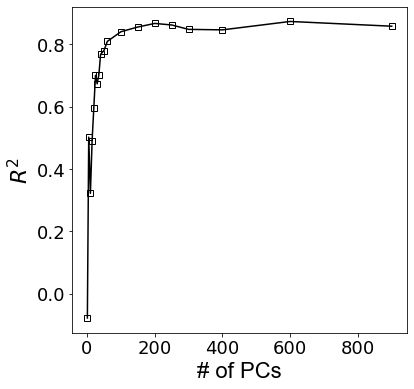

19
19


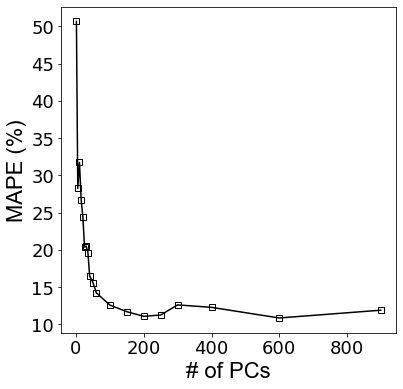

In [42]:
# R2 vs PC 
# creating data
pcs=[1,5,10,15,20,25,30,35,40,50,60,100,150,200,250,300,400,600,900]
r2_vals=[]
mape_vals=[]
for i in range(len(pcs)):
	pred,ytest=pca_mlp(pcs[i])
	r2_vals.append(r2_score(ytest,pred))
	mape_vals.append(mean_absolute_percentage_error(ytest,pred))
print(len(pcs))	
plt.figure(figsize=(6,6))
plt.plot(pcs, r2_vals,'-s', fillstyle='none',color='black')
plt.xlabel('# of PCs', fontproperties=arial)
plt.ylabel(r'$R^2$', fontproperties=arial)
plt.savefig('./Figures/pcs_r2.png')      
plt.show()
print(len(mape_vals))
print(len(pcs))
mape_vals=np.array(mape_vals)
mape_vals *=100

#mape_vals=np.array(mape_vals)*100
plt.figure(figsize=(6,6))

plt.plot(pcs, mape_vals,'-s', fillstyle='none',color='black')
plt.xlabel('# of PCs', fontproperties=arial)
plt.ylabel(r'MAPE (%)', fontproperties=arial)
plt.savefig('./Figures/pcs_mape.png')      
plt.show()



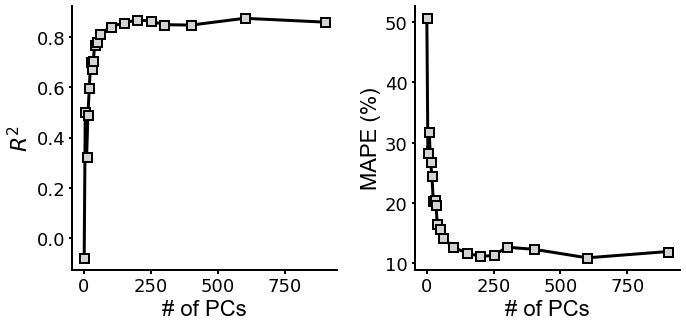

In [77]:
'''
plt.figure(figsize=(6,6))
plt.plot(pcs, r2_vals,'-s', fillstyle='none',color='black')
plt.xlabel('# of PCs', fontproperties=arial)
plt.ylabel(r'$R^2$', fontproperties=arial)
plt.savefig('./Figures/pcs_r2.png')      
plt.show()
print(len(mape_vals))
print(len(pcs))
mape_vals=np.array(mape_vals)
mape_vals *=100

#mape_vals=np.array(mape_vals)*100
plt.figure(figsize=(6,6))

plt.plot(pcs, mape_vals,'-s', fillstyle='none',color='black')
plt.xlabel('# of PCs', fontproperties=arial)
plt.ylabel(r'MAPE (%)', fontproperties=arial)
plt.savefig('./Figures/pcs_mape.png')      
plt.show()

'''

plt.rcParams.update({'font.size': 22,    # Default font size
                     'axes.titlesize': 2,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18})

arial_font_path='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
arial=font_manager.FontProperties(fname=arial_font_path)
sets=[[[5,10],[5,200]],
[[40,10],[40,200]]]

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(pcs, r2_vals,'-s', linewidth=3,markersize=9,markeredgewidth=2,markerfacecolor='lightgray',color='black')
axs[0].set_xlabel('# of PCs', fontproperties=arial)
axs[0].set_ylabel(r'$R^2$', fontproperties=arial)

axs[1].plot(pcs, mape_vals,'-s',linewidth=3,markersize=9,markeredgewidth=2,markerfacecolor='lightgray',color='black')
axs[1].set_xlabel('# of PCs', fontproperties=arial)
axs[1].set_ylabel(r'MAPE (%)', fontproperties=arial)

axs[1].tick_params(axis='y', which='both', bottom=True, top=False, labelbottom=False)

for ax in axs.flat:
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)  # Set bottom spine (line) thickness to 2
    ax.spines['left'].set_linewidth(2) 
    ax.tick_params(axis='both', which='major', width=2)
# Adjust the spacing between the subplots
#plt.tight_layout()

plt.tight_layout()

     
plt.show()

(12901, 10, 5) (12901,)
273/273 [==============================] - 0s 1ms/step
Time: 0.39657058101147413 Data 8711
(12871, 40, 5) (12871,)
273/273 [==============================] - 0s 1ms/step
Time: 0.43795857299119234 Data 8711
(12851, 60, 5) (12851,)
273/273 [==============================] - 0s 610us/step
Time: 0.22757323505356908 Data 8711
(12811, 100, 5) (12811,)
273/273 [==============================] - 0s 627us/step
Time: 0.23605534492526203 Data 8711
(12711, 200, 5) (12711,)
273/273 [==============================] - 0s 655us/step
Time: 0.2523533209459856 Data 8711
(12901, 10, 10) (12901,)
273/273 [==============================] - 0s 1ms/step
Time: 0.42305911297444254 Data 8711
(12871, 40, 10) (12871,)
273/273 [==============================] - 0s 746us/step
Time: 0.26996666903141886 Data 8711
(12851, 60, 10) (12851,)
273/273 [==============================] - 0s 854us/step
Time: 0.2990849500056356 Data 8711
(12811, 100, 10) (12811,)
273/273 [==============================] 

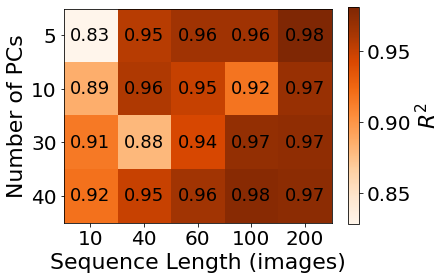

In [44]:
# Create Spatial Plot 
# Using PCA-CNN Model since best performance

plt.rcParams.update({'font.size': 18,    # Default font size
                     'axes.titlesize': 20,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 20,  # X-axis tick label font size
                     'ytick.labelsize': 20}) # Y-axis tick label font size

# Flatten the 2D array of subplots into a 1D array
sets=[[[5,10],[5,40],[5,60],[5,100],[5,200]],
[[10,10],[10,40],[10,60],[10,100],[10,200]],
[[30,10],[30,40],[30,60],[30,100],[30,200]],
[[40,10],[40,40],[40,60],[40,100],[40,200]]]
data_ts=np.array([[0. for i in range(len(sets[0]))] for j in range(len(sets))])
for i in range(len(sets)):
	for j in range(len(sets[0])):
		pred,ytest=pca_cnn_model(sets[i][j][0], sets[i][j][1])
		data_ts[i][j]=r2_score(ytest,pred)
		
cmap=plt.get_cmap('Oranges')
plt.imshow(data_ts, cmap=cmap)
cbar=plt.colorbar()
cbar.set_label(r'$R^2$')
true_labels = ['5', '10', '30', '40']
predicted_labels = ['10', '40', '60', '100', '200']

plt.xticks(np.arange(len(predicted_labels)), predicted_labels)
plt.yticks(np.arange(len(true_labels)), true_labels)
plt.xlabel('Sequence Length (images)')
plt.ylabel('Number of PCs')
# Add text annotations to each cell
for i in range(len(true_labels)):
    for j in range(len(predicted_labels)):
        plt.text(j, i, f'{data_ts[i, j]:.2f}', ha='center', va='center', color='black')

plt.show()

In [ ]:
sets=[[[5,10],[5,200]],
[[40,10],[40,200]]]
plt.figure(figsize=(10, 8))  # Adjust the size of the entire figure


for i in range(len(sets)):
    for j in range(len(sets[0])):
        pcs, sl = sets[i][j]
        pred, ytest = pca_cnn_model(pcs, sl)

        # Create the subplot
        plt.subplot(2, 2, i*2+j+1)
        plt.plot(ytest, pred, 'o', color='#FF7F0E')
        plt.plot([10, 100], [10, 100], color='black')
        plt.title(f'PCA-CNN {pcs} pcs {sl} sl', fontproperties=arial, fontsize=26)
        plt.xlabel('True', fontproperties=arial, fontsize=24)
        plt.ylabel('Predicted', fontproperties=arial, fontsize=24)
        plt.axis('equal')

for ax in axs.flat:
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)  # Set bottom spine (line) thickness to 2
    ax.spines['left'].set_linewidth(2) 
    ax.tick_params(axis='both', which='major', width=2)
    
fig.text(0.5, 0.04, r'Heat Flux Label ($W/cm^2$)', ha='center', va='center')
fig.text(0.06, 0.5, r'Predicted Heat Flux ($W/cm^2$)', ha='center', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# Add some spacing between subplots
#plt.tight_layout()

# Show the plot
plt.show()

(12901, 10, 5) (12901,)
273/273 [==============================] - 1s 2ms/step
Time: 0.6037027640268207 Data 8711
(12711, 200, 5) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.36915242904797196 Data 8711
(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 843us/step
Time: 0.29227494390215725 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 1s 2ms/step
Time: 0.7146704939659685 Data 8711


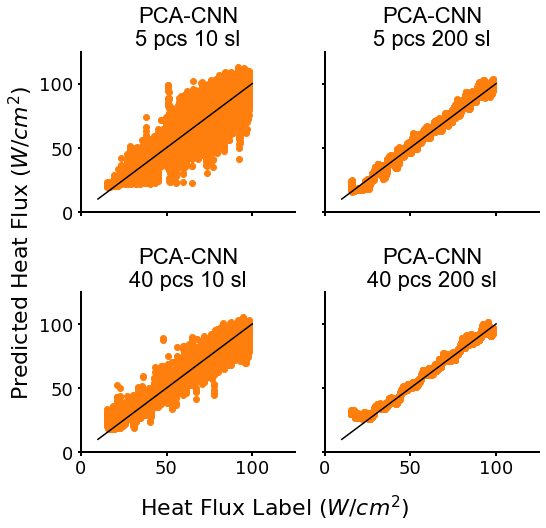

In [40]:

plt.rcParams.update({'font.size': 22,    # Default font size
                     'axes.titlesize': 2,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18})

arial_font_path='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
arial=font_manager.FontProperties(fname=arial_font_path)
sets=[[[5,10],[5,200]],
[[40,10],[40,200]]]

fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i in range(len(sets)):
    for j in range(len(sets[0])):
        pcs, sl = sets[i][j]
        pred, ytest = pca_cnn_model(pcs, sl)
        axs[i,j].plot(ytest, pred, 'o', color='#FF7F0E')
        axs[i,j].plot([10, 100], [10, 100], color='black')
        axs[i,j].set_title(f'PCA-CNN\n{pcs} pcs {sl} sl', fontproperties=arial, fontsize=22)
        axs[i,j].set_xlim([0,125])
        axs[i,j].set_ylim([0,125])

        
axs[0,0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
axs[0,0].tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
axs[0,1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
axs[0,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
axs[1,0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[1,0].tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
axs[1,1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axs[1,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

# Hide the remaining empty subplots
#axs[0, 2].axis('off')
for ax in axs.flat:
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)  # Set bottom spine (line) thickness to 2
    ax.spines['left'].set_linewidth(2) 
    ax.tick_params(axis='both', which='major', width=2)
# Adjust the spacing between the subplots
#plt.tight_layout()
fig.text(0.5, 0.04, r'Heat Flux Label ($W/cm^2$)', ha='center', va='center')
fig.text(0.06, 0.5, r'Predicted Heat Flux ($W/cm^2$)', ha='center', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plots
plt.savefig('./Figures/predvstrue.png')      
plt.show()

(12901, 10, 5) (12901,)
273/273 [==============================] - 0s 698us/step
Time: 0.24890022305771708 Data 8711
(12711, 200, 5) (12711,)
273/273 [==============================] - 0s 841us/step
Time: 0.2998288441449404 Data 8711
(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 589us/step
Time: 0.22074316488578916 Data 8711
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.44328694394789636 Data 8711


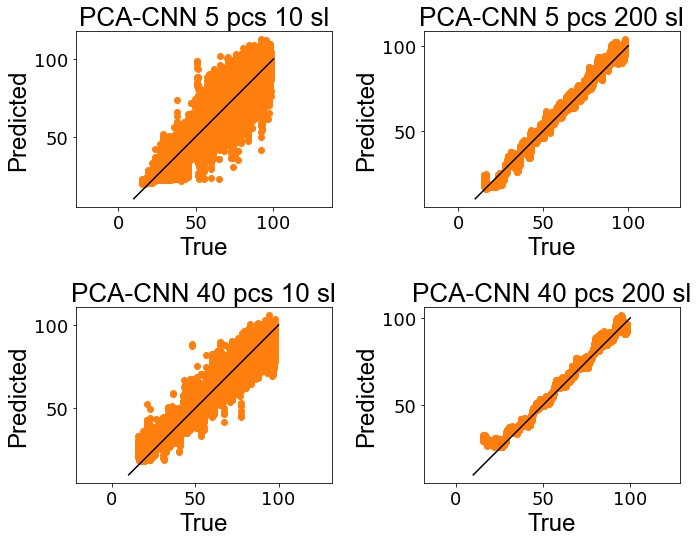

In [18]:
sets=[[[5,10],[5,200]],
[[40,10],[40,200]]]
plt.figure(figsize=(10, 8))  # Adjust the size of the entire figure

plt.rcParams.update({'font.size': 22,    # Default font size
                     'axes.titlesize': 24,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18}) # Y-axis tick label font size

for i in range(len(sets)):
    for j in range(len(sets[0])):
        pcs, sl = sets[i][j]
        pred, ytest = pca_cnn_model(pcs, sl)

        # Create the subplot
        plt.subplot(2, 2, i*2+j+1)
        plt.plot(ytest, pred, 'o', color='#FF7F0E')
        plt.plot([10, 100], [10, 100], color='black')
        plt.title(f'PCA-CNN {pcs} pcs {sl} sl', fontproperties=arial, fontsize=26)
        plt.xlabel('True', fontproperties=arial, fontsize=24)
        plt.ylabel('Predicted', fontproperties=arial, fontsize=24)
        plt.axis('equal')

# Add some spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

(12901, 10, 5) (12901,)
273/273 [==============================] - 0s 758us/step
Time: 0.2652362431399524 Data 8711


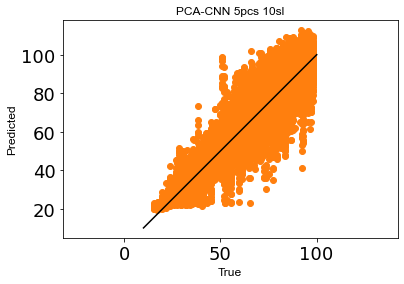

(12711, 200, 5) (12711,)
273/273 [==============================] - 0s 715us/step
Time: 0.26494827400892973 Data 8711


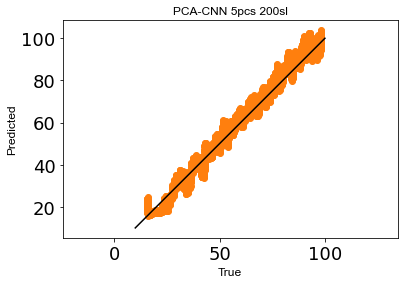

(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 795us/step
Time: 0.2827010960318148 Data 8711


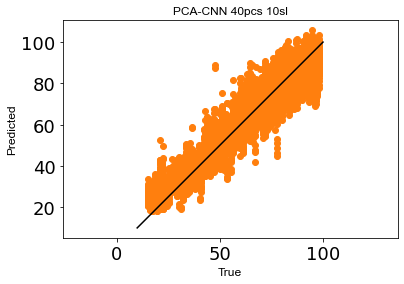

(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
Time: 0.47906543617136776 Data 8711


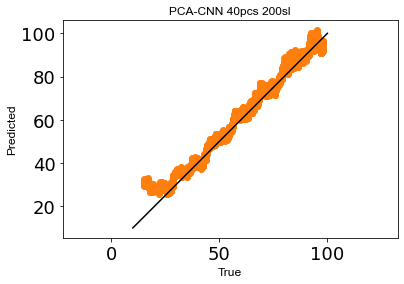

TypeError: slice indices must be integers or None or have an __index__ method

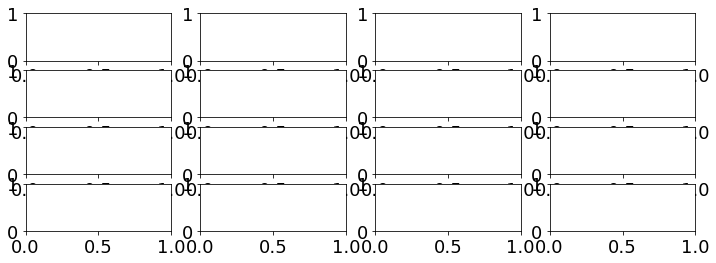

In [19]:
for i in range(len(sets)):
	for j in range(len(sets[0])):
		pred,ytest=pca_cnn_model(sets[i][j][0], sets[i][j][1])
		plt.plot(ytest,pred, 'o', color='#FF7F0E')
		plt.plot([10,100],[10,100], color='black')
		plt.title(f'PCA-CNN {sets[i][j][0]}pcs {sets[i][j][1]}sl',fontproperties=arial, fontsize=12)
		plt.xlabel('True', fontproperties=arial, fontsize=12)
		plt.ylabel('Predicted', fontproperties=arial, fontsize=12)
		plt.axis('equal')
		plt.show()


fig, axes = plt.subplots(4, 4, figsize=(12, 4))
axes = axes.flatten()

# Plot your figures
for i in range(len(sets)):
    ax = axes[i]
    pred,ytest=pca_cnn_model(sets[i][0],sets[i][1])
    print(r2_score(ytest,pred))
    # Example plot
    ax.plot(pred,ytest,'o')
    ax.plot([10,100],[10,100],color='black')
    string="{:.3f}".format(r2_score(ytest,pred))+","+"{:.3f}".format(mean_absolute_percentage_error(ytest,pred))
    ax.text(0,85,string)
    ax.set_title(f'pc{sets[i][0]} sl{sets[i][1]}')  # Set subplot title

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig('./Figures/tempvsspatial.png')      
plt.show()
